2000-01-01 00:10:00
2000-01-01 00:20:00
2000-01-01 00:30:00
2000-01-01 00:40:00
2000-01-01 00:50:00
2000-01-01 01:00:00
2000-01-01 01:10:00
2000-01-01 01:20:00
2000-01-01 01:30:00
2000-01-01 01:40:00
2000-01-01 01:50:00
2000-01-01 02:00:00
2000-01-01 02:10:00
2000-01-01 02:20:00
2000-01-01 02:30:00
2000-01-01 02:40:00
2000-01-01 02:50:00
2000-01-01 03:00:00
2000-01-01 03:10:00
2000-01-01 03:20:00
2000-01-01 03:30:00
2000-01-01 03:40:00
2000-01-01 03:50:00
2000-01-01 04:00:00
2000-01-01 04:10:00
2000-01-01 04:20:00
2000-01-01 04:30:00
2000-01-01 04:40:00
2000-01-01 04:50:00
2000-01-01 05:00:00
2000-01-01 05:10:00
2000-01-01 05:20:00
2000-01-01 05:30:00
2000-01-01 05:40:00
2000-01-01 05:50:00
2000-01-01 06:00:00
2000-01-01 06:10:00
2000-01-01 06:20:00
2000-01-01 06:30:00
2000-01-01 06:40:00
2000-01-01 06:50:00
2000-01-01 07:00:00
2000-01-01 07:10:00
2000-01-01 07:20:00
2000-01-01 07:30:00
2000-01-01 07:40:00
2000-01-01 07:50:00
2000-01-01 08:00:00
2000-01-01 08:10:00
2000-01-01 08:20:00


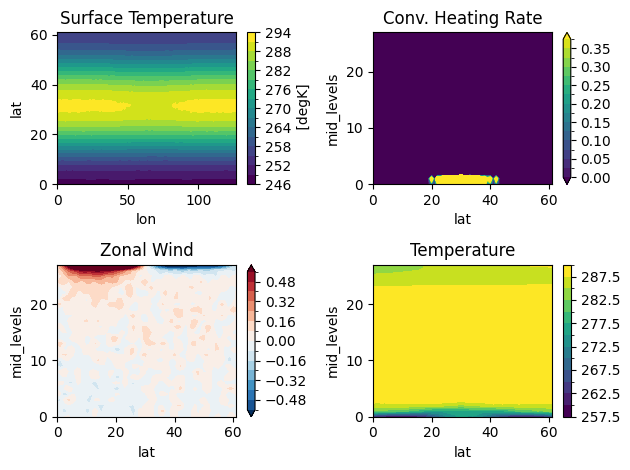

In [1]:
import climt
from sympl import (
    PlotFunctionMonitor,
    TimeDifferencingWrapper, UpdateFrequencyWrapper,
)
import numpy as np
from datetime import timedelta
from gfs_dynamical_core import GFSDynamicalCore


def plot_function(fig, state):

    ax = fig.add_subplot(2, 2, 1)
    state['surface_temperature'].plot.contourf(
        ax=ax, levels=16, robust=True)
    ax.set_title('Surface Temperature')

    ax = fig.add_subplot(2, 2, 3)
    state['eastward_wind'].mean(dim='lon').plot.contourf(
        ax=ax, levels=16, robust=True)
    ax.set_title('Zonal Wind')

    ax = fig.add_subplot(2, 2, 2)
    state['air_temperature_tendency_from_convection'].transpose().mean(
        dim='lon').plot.contourf(
        ax=ax, levels=16, robust=True)
    ax.set_title('Conv. Heating Rate')

    ax = fig.add_subplot(2, 2, 4)
    state['air_temperature'].mean(dim='lon').plot.contourf(
        ax=ax, levels=16)
    ax.set_title('Temperature')

    fig.tight_layout()


# Create plotting object
monitor = PlotFunctionMonitor(plot_function)

climt.set_constants_from_dict({
    'stellar_irradiance': {'value': 1200, 'units': 'W m^-2'}})

model_time_step = timedelta(seconds=600)
# Create components


convection = climt.EmanuelConvection()
simple_physics = TimeDifferencingWrapper(climt.SimplePhysics())

constant_duration = 6

radiation_lw = UpdateFrequencyWrapper(
    climt.RRTMGLongwave(), constant_duration*model_time_step)

radiation_sw = UpdateFrequencyWrapper(
    climt.RRTMGShortwave(), constant_duration*model_time_step)

slab_surface = climt.SlabSurface()
insolation = climt.Instellation()

dycore = GFSDynamicalCore(
    [simple_physics, slab_surface, radiation_sw,
     radiation_lw, convection],
    number_of_damped_levels=5
)
grid = climt.get_grid(nx=128, ny=62)

# Create model state
my_state = climt.get_default_state([dycore], grid_state=grid)

# Set initial/boundary conditions
latitudes = my_state['latitude'].values
longitudes = my_state['longitude'].values

zenith_angle = np.radians(latitudes)
surface_shape = [len(longitudes), len(latitudes)]

my_state['zenith_angle'].values = zenith_angle
my_state['eastward_wind'].values[:] = np.random.randn(
    *my_state['eastward_wind'].shape)
my_state['ocean_mixed_layer_thickness'].values[:] = 1

surf_temp_profile = 290 - (40*np.sin(zenith_angle)**2)
my_state['surface_temperature'].values = surf_temp_profile

for i in range(24*6):
    diagnostics = insolation(my_state)
    my_state.update(diagnostics)
    diag, my_state = dycore(my_state, model_time_step)
    my_state.update(diag)
    my_state['time'] += model_time_step

    if i % 6 == 0:
        monitor.store(my_state)

    print(my_state['time'])